# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [38]:
from PIL import Image, ImageDraw
from IPython.display import display
import pytesseract
import cv2 as cv
import numpy as np
import zipfile

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('assets/haarcascade_frontalface_default.xml')

# the rest is up to you!

We're going to process images stored in a ZIP file.

We're creating two lists, one to store PIL (Python Imaging Library) Image objects (pil_pages) and another to store these images as numpy arrays (array_pages). 

PIL Image objects provide a lot of useful methods for image processing.

Numpy arrays give us ability to process images in numerical ways, which is needed for machine learning methods.

In [39]:
pil_pages = []
array_pages = []

# We're using 'with' keyword to handle the zipfile. This is a good practice as it automatically closes the file after we're done.
# We're opening the ZIP file in 'r' (read) mode.
with zipfile.ZipFile('assets/images.zip', 'r') as img_zip:
    # Loop through each file in the zip file. The method .infolist() returns a list with information about all the files.
    for item in img_zip.infolist():
        # Open each file in the zip. This is needed as we're dealing with a compressed file.
        # Again, we use 'with' keyword to handle the file properly.
        with img_zip.open(item) as file:
            # Open the image file as a PIL Image and convert it to RGB.
            # We convert the image to RGB as some images might be grayscale or in other formats, but we want consistency.
            page = Image.open(file).convert('RGB')
            # Add the PIL Image object to the pil_pages list.
            pil_pages.append(page)
            # Convert the image to grayscale and then to a numpy array. 
            # The 'L' mode stands for grayscale. We use grayscale because it simplifies the image and reduces computation needs for later processes.
            array = np.array(page.convert('L'))
            # Add the numpy array image to the array_pages list.
            array_pages.append(array)

We're going to use OpenCV to detect faces in the images. For that, we're creating a list 'all_faces' to store the locations of faces detected in each image.

In [40]:
all_faces = []

# We'll loop through each image. Note that 'array_pages' contains the images in the form of numpy arrays.
for img in array_pages:
    # Use the 'detectMultiScale' method of 'face_cascade' object (a pre-trained OpenCV Haar cascade classifier) 
    # to detect faces in the image. This method returns a list of rectangles where it believes it found a face. 
    # Each rectangle is represented as a list of 4 integers specifying the top-left point and the width and height.
    # We're passing two parameters to 'detectMultiScale': the grayscale image and a scale factor. 
    # The scale factor compensates for some faces being more in the foreground or background than others.
    faces = face_cascade.detectMultiScale(img, 1.3469)
    
    # Append the faces detected in the current image to the 'all_faces' list.
    all_faces.append(faces)

We are going to combine all the information we have into a single dictionary called 'pages_dict'.
The key of this dictionary will be the name of each image file and the value will be a list containing:
1. The PIL Image object of the image.
2. The numpy array of the grayscale image.
3. The list of detected faces in the image.

In [41]:
pages_dict = {}

# We're looping through the names of all the files in the ZIP file using the 'namelist()' method of the zip file object.
# Note that the number of images equals the length of 'img_zip.namelist()'.
for i in range(len(img_zip.namelist())):
    # We're setting the key of 'pages_dict' as the name of the image file and the value as a list containing 
    # the PIL Image object, the numpy array of the image, and the list of detected faces.
    # We use 'i' to index the correct items from 'pil_pages', 'array_pages', and 'all_faces'.
    pages_dict[img_zip.namelist()[i]] = [pil_pages[i], array_pages[i], all_faces[i]]


Now, we'll crop the faces out of each image using the rectangles provided by the face detection.

We're going to store the cropped faces in the 'all_cropped_faces' list.

Each element of 'all_cropped_faces' will itself be a list containing the cropped faces from one image.

In [42]:
all_cropped_faces = []

# Loop through the names of all the files in the ZIP file.
for name in img_zip.namelist():
    # Create an empty list to store the cropped faces for this image.
    cropped_faces = [] 

    # Loop through the list of faces (rectangles) detected in this image. 
    # The format of each face is (x, y, w, h), where x and y specify the top-left point of the rectangle,
    # and w and h are the width and height of the rectangle.
    for (x,y,w,h) in pages_dict[name][2]:
        # Use the 'crop' method of the PIL Image object to crop the face out of the image.
        # We're passing a tuple specifying the left, upper, right, and lower pixel coordinates.
        cropped_face = pages_dict[name][0].crop((x,y,x+w,y+h))
        # Use the 'thumbnail' method of the PIL Image object to resize the cropped face 
        # so that it fits within a 128x128 box, but maintains its aspect ratio.
        cropped_face.thumbnail((128,128))
        # Add the cropped face to the 'cropped_faces' list for this image.
        cropped_faces.append(cropped_face)

    # Add the list of cropped faces for this image to the 'all_cropped_faces' list.
    all_cropped_faces.append(cropped_faces)

In [43]:
# Here we're going to create contact sheets from all the cropped faces.
# A contact sheet is an image that contains several smaller images.
# We're storing these contact sheets in the 'contact_sheets' list.
# We're also going to add these contact sheets to the 'pages_dict' dictionary.

# Get the first cropped face image, we'll use this to determine the size of the individual images on the contact sheets.
first_image=all_cropped_faces[0][0]

# Initialize an empty list to store the contact sheets.
contact_sheets = []

# Loop through each list of cropped faces.
for faces in all_cropped_faces:
    # If there are 5 or fewer faces, we'll make a contact sheet that is 5 faces wide and 1 face tall.
    if len(faces) <= 5:
        contact_sheet=Image.new(first_image.mode, (first_image.width*5, first_image.height))
    # If there are more than 5 faces, we'll make a contact sheet that is 5 faces wide and n faces tall, where n is enough to fit all faces.
    else:
        contact_sheet=Image.new(first_image.mode, (first_image.width*5, first_image.height * (int(len(faces)/5) + 1)))

    # Initialize the position for the first face as the top-left corner of the contact sheet.
    x=0
    y=0

    # Loop through each face.
    for face in faces:
        # Paste the face at the current position on the contact sheet.
        contact_sheet.paste(face, (x, y))
    
        # If we've filled up a row on the contact sheet, move to the start of the next row.
        if x+first_image.width == contact_sheet.width:
            x=0
            y=y+first_image.height
        # Otherwise, move to the next column in the current row.
        else:
            x=x+first_image.width

    # Add the contact sheet to the 'contact_sheets' list.
    contact_sheets.append(contact_sheet)

# Now we'll add these contact sheets to the 'pages_dict' dictionary.
for i in range(len(img_zip.namelist())):
    # We're adding the contact sheet as the fourth item (index 3) in the list of values for each image file in 'pages_dict'.
    pages_dict[img_zip.namelist()[i]].append(contact_sheets[i])   

In this section, we'll use pytesseract to perform Optical Character Recognition (OCR) on each image 
to extract the text. This text will be added to 'pages_dict' at index 4.


In [44]:
# Specify the path to the Tesseract executable. Tesseract is an open source OCR engine that we're using to extract text from the images.
# Note: This path needs to be updated according to your own system's configuration.
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# Loop through each image in 'pages_dict'.
for key in pages_dict:
    # Use pytesseract's 'image_to_string' function to extract the text from the image.
    # We convert the image to black and white (mode '1') before passing it to 'image_to_string'.
    text = pytesseract.image_to_string(pages_dict[key][0].convert('1'))

    # Convert the text to lowercase to make the search case-insensitive.
    text = text.lower()

    # Import the 'string' module, which contains useful constants and classes for string manipulation.
    import string
    # Initialize an empty string to store the processed text.
    comparison=''

    # Loop through each character in the text.
    for character in text:
        # If the character is a lowercase letter (i.e., it's in 'string.ascii_lowercase'), add it to 'comparison'.
        # This effectively removes all non-alphabetical characters from the text.
        if character in string.ascii_lowercase:
            comparison=comparison+character

    # Append the processed text to the list of values for this image file in 'pages_dict'.
    pages_dict[key].append(comparison)


now the pages_dict is complete in this format:

`{'filename': [PIL.Image, np-array image, face coordinates, contact sheet, page text]}`

Now we'll create a search function that allows the user to input a keyword, 
and then finds and displays the contact sheets for all images where the keyword is found in the text.

results found in file a-0.png


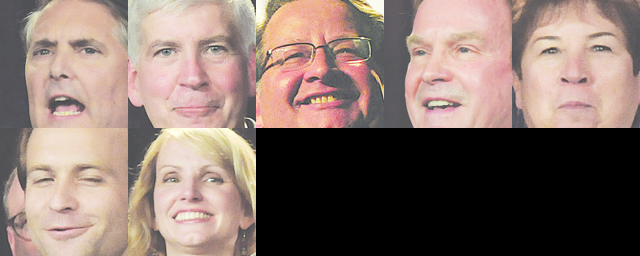

results found in file a-1.png


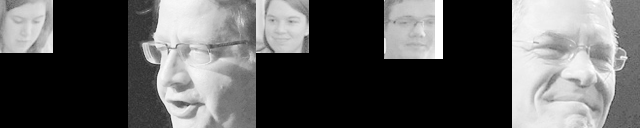

results found in file a-10.png


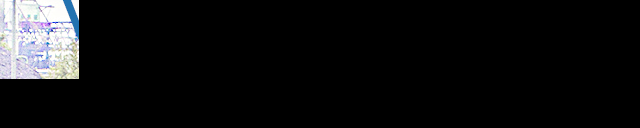

results found in file a-13.png


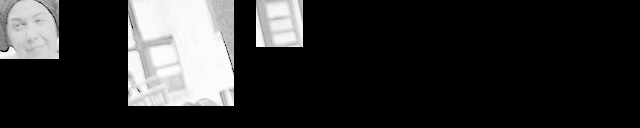

results found in file a-2.png


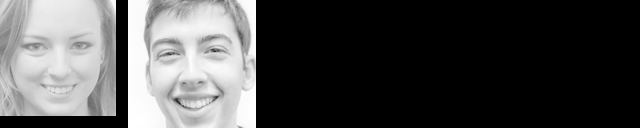

results found in file a-3.png


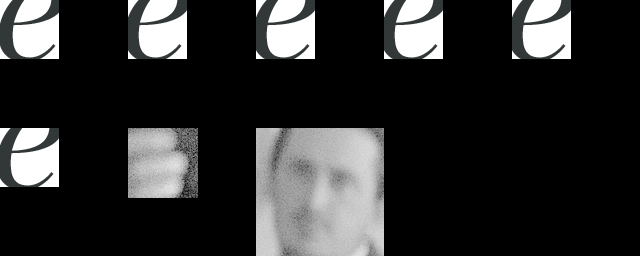

results found in file a-5.png


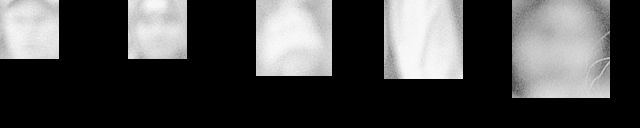

results found in file a-8.png


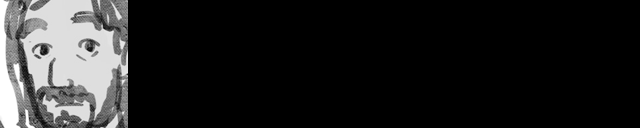

results found in file a-9.png


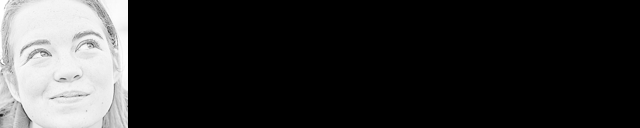

In [45]:
# Get the search string from the user input. This is case-sensitive, so 'pizza' will not match 'Pizza'.
search_str = input("Enter a keyword to search: ")

# Convert the search string to lowercase to make the search case-insensitive.
search_str = search_str.lower()

# Loop through each image in 'pages_dict'.
for key in pages_dict:
    # If the search string is found in the text for this image (at index 4 in the list of values),
    # print a message and display the contact sheet for this image.
    if search_str in pages_dict[key][4]:
        print("results found in file " + key)
        display(pages_dict[key][3])  # contact sheet is at index 3
